***
# HCI Week 3 - Coronagraphs Part I
*Matthew Kenworthy // Leiden Observatory*
***

Today, in [*Questions 3.1*](#part1) *- 3.5*, we will go though the steps of determining encircled energy as a function of radius for a circular telescope pupil:
> *Step 1: Create the telescope pupil*<br>
> *Step 2: Conserving flux from Pupil to Focal Planes*<br>
> *Step 3: Calculating encircled energy as a function of radius*

Thereafter, in [*Questions 3.6*](#part2) *- 3.16*, you will simulate you own simple Lyot coronagraph. 

For a cool NASA animation on how a Lyot Coronograph works, see [this link](https://exoplanets.nasa.gov/resources/2130/coronagraph-explanation-2-minutes/).


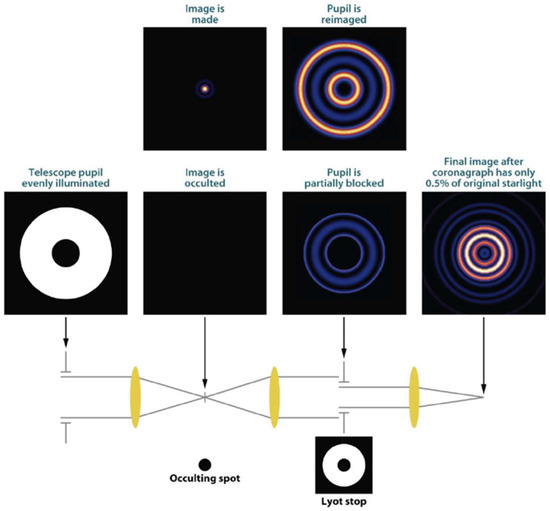
[Image credits: geoSciences](https://www.mdpi.com/journal/geosciences/special_issues/extrasolar_planets)

<div class="alert alert-block alert-info">
<b>Tip:</b> Read through the functions defined in the block below, as they may help with the exercises.</div>


Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

Load in some functions we will use later: `displC`, `padcplx`, `FFT`, `IFFT`, `phi_ramp` and `logit`

In [2]:
def displC(c, title="Amplitude-Phase space of the PSF", trim=101, show=True):
    """displC(c,trim=0) - display a Complex number c as four plots
    
               The top two plots are (Real, Imaginary) quantities
               The bottom two plots are (Amplitude, Phase)
               
               Optionally cut out the central square  with a size of 'trim x trim' pixels"""   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2 + 1)
        dy = int((nx-trim) / 2 + 1)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    #     fig=plt.figure(figsize=(12,12),
    #                   sharex=True, sharey=True) 
    # who does this like that????

    fig, ((axre, axim), (axamp, axpha)) = plt.subplots(nrows=2, ncols=2,
                         constrained_layout=True,
                         sharex=True,
                         sharey=True,
                         figsize=(12, 12))
    
    # plot out the panels
    im = axre.imshow(c2.real)
    plt.colorbar(im, ax=axre, fraction=0.046, pad=0.04, label="")
    im = axim.imshow(c2.imag)
    plt.colorbar(im, ax=axim, fraction=0.046, pad=0.04, label="")
    im = axamp.imshow(np.abs(c2))
    plt.colorbar(im, ax=axamp, fraction=0.046, pad=0.04, label="")
    im = axpha.imshow(np.angle(c2))
    plt.colorbar(im, ax=axpha, fraction=0.046, pad=0.04, label="")
    

    axre.set_title('Real')
    axre.set_ylabel('y [px]')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axamp.set_xlabel('x [px]')
    axamp.set_ylabel('y [px]')
    axpha.set_title('Phase')
    axpha.set_xlabel('x [px]')
    plt.suptitle(title, fontsize=18)
    if show:
        plt.show()

def padcplx(c,pad=5):
    """padcplx(c,pad=5) - puts a `Complex` array into the centre of a zero-filled `Complex` array
               pad is an integer defining the padding multiplier for the output array """
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = np.array((nx * (pad-1)) / 2).astype(int)
    dy = np.array((ny * (pad-1)) / 2).astype(int)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT(c,pad=5) - carry out a complex Fourier transform (with optional padding)
            c - the input 2D Complex numpy array
            pad - integer multiplier for the padding/sampling
            Returns the `Complex` FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(c,pad=5):
    """IFFT(c,pad=5) - carry out the complex Fourier transform (with optional padding)
            and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(ifft2(ifftshift(padcplx(c,pad))))
    return psfA

def r_theta(im, xc, yc):
    """r_theta(im, xc, yc) - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    """phi_ramp(im, npx, npy) - make an X-ramp, making the 0 be in the middle, make it -0.5 to +0.5 and make it -pi to +pi. """
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2 # literall, please explain, why would you do it like this???
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2 # I cant comprehend this
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def logit(im, minlog=-6):
    """logit(im, minlog=-6) - takes the log10 of an image and rounds up tiny logs to minlog so that displC()
            works better. """
    imout = np.copy(im)
    logimout = np.log10(imout)
    logimout[(logimout<minlog)] = minlog
    return(logimout)

### My own functions from last time

In [3]:
def ellipse_distance(im, xc, yc, a=1, b=1, rot=0, **kwargs): # its actually a elliptical mask but what can one do...
    '''
    construct float arr over some (gridded) array where the elements are the distances from some center xc, yc
    :param xc: (float) center of ellipse, x direction
    :param yc: (float) center of ellipse, y direction
    :param a: (float) length of semi-major axis
    :param b: (float) length of semi-minor axis
    :param rot: (float) rotation angle of the ellipse, pass in *DEG*, positive counter clock wise
    :return: (np.array) masked array over x,y with arr<1 inside ellipse
    '''
    y, x = np.mgrid[0:im.shape[0],0:im.shape[1]]
    rot = np.deg2rad(rot)
    rad2 = (((x - xc) * np.cos(rot) + (y - yc) * np.sin(rot)) / a) ** 2 + (
            ((x - xc) * np.sin(rot) - (y - yc) * np.cos(rot)) / b) ** 2
    
    return np.sqrt(rad2)

def circle_mask(im, xc, yc, rcirc, a=1, b=1, rot=0, **kwargs): # its actually a elliptical mask but what can one do...
    '''
    construct elliptical or circular mask over some array centered at xc, yc wit r rcirc (might be scaled for ellipses) 
    :param xc: (float) center of ellipse, x direction
    :param yc: (float) center of ellipse, y direction
    :param a: (float) length of semi-major axis
    :param b: (float) length of semi-minor axis
    :param rot: (float) rotation angle of the ellipse, pass in *DEG*, positive counter clock wise
    :return: (np.array) array  with arr=1 inside ellipse
    '''
    r = ellipse_distance(im, xc, yc, a, b, rot, **kwargs)
    r = (r < rcirc).astype(bool)
    return r

<a id='part1'></a>

## Step 1: Create the telescope pupil

The first stage in the process of simulating our Lyot coronograph is to create a telescope pupil. The pupil is a circular aperture with no central obscuration. In a square grid we simulate this circular pupil using a circular mask. Be aware: the circle must touch all four sides of the square. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.1</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make a telescope pupil with a diameter of 61 pixels. The pupil is circular with no central obscuration. Turn the circular pupil into complex amplitude pupil with an amplitude per pixel of 1 and zero phase. Call this the telescope pupil `A`.**

---

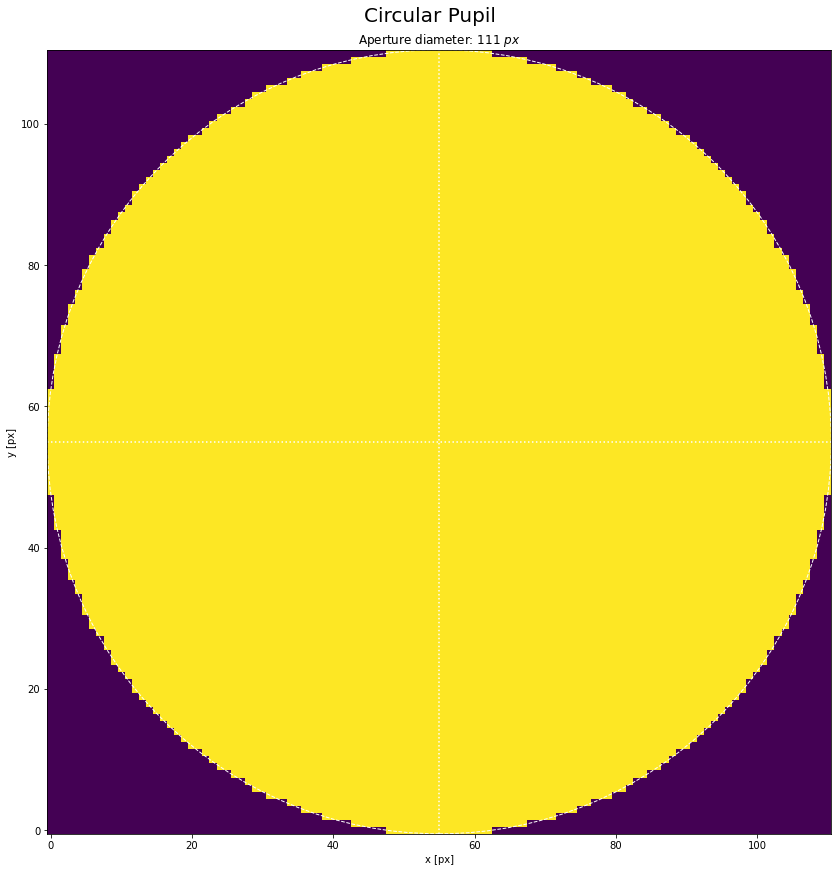

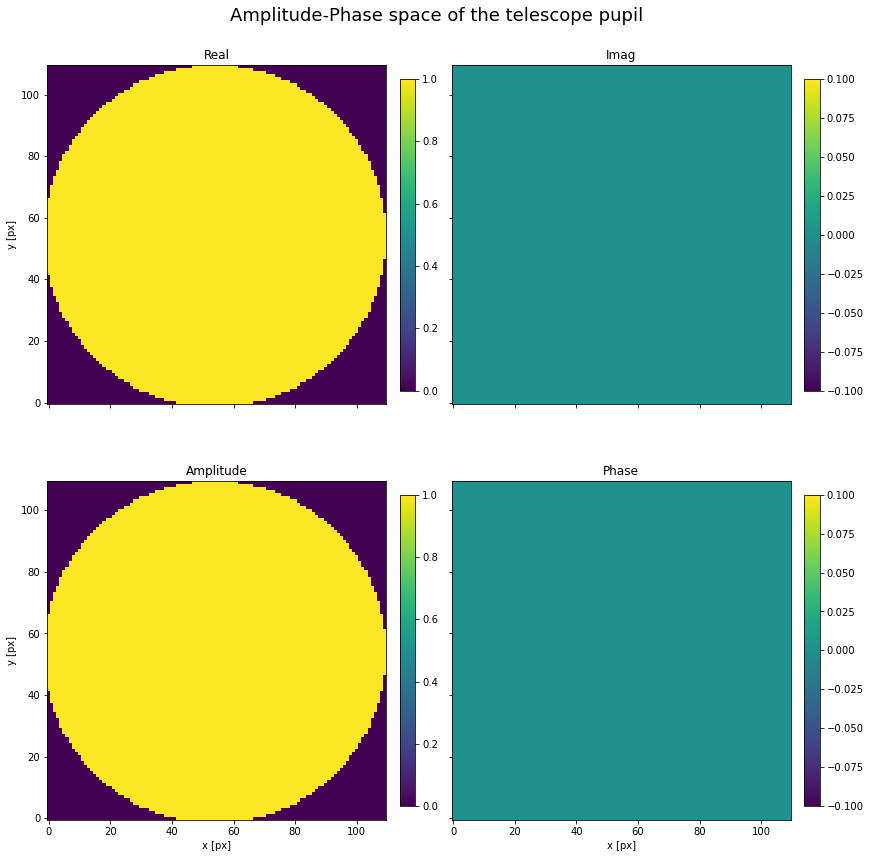

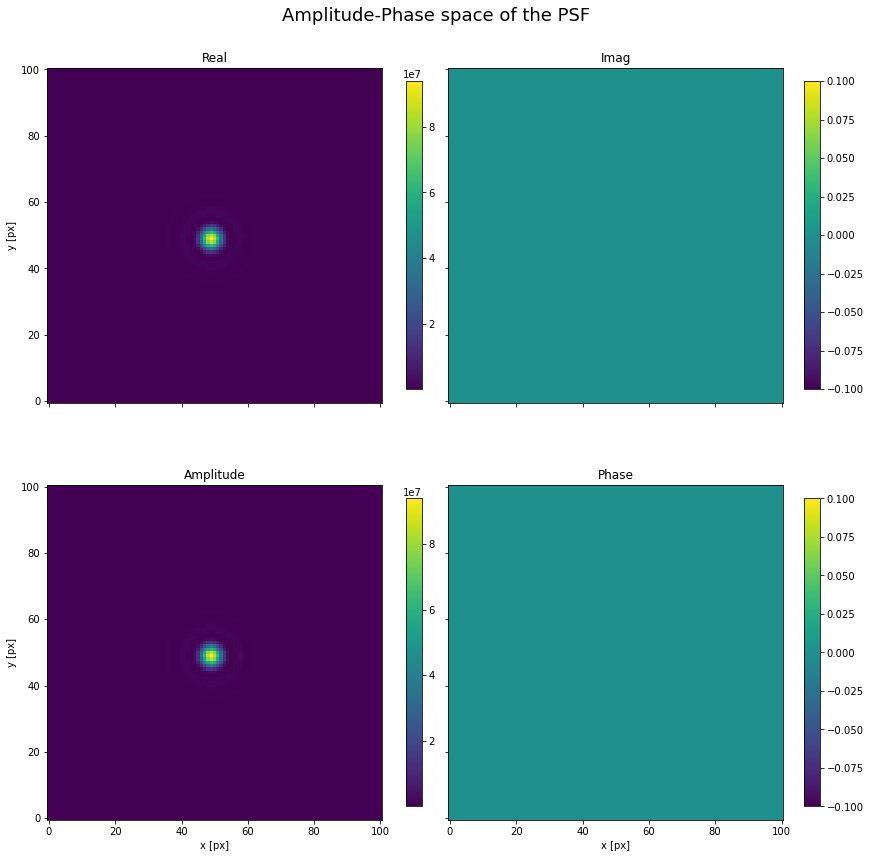

In [4]:
dtel = 111 # pixels ???, come on...

# Q1 answer here

phase = np.zeros((dtel, dtel))
A = circle_mask(phase, (dtel-1)/2, (dtel-1)/2, dtel/2)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))
plt.imshow(A)
ax.axvline((dtel-1)/2, c="w", ls="dotted")
ax.axhline((dtel-1)/2, c="w", ls="dotted")

p = mpl.patches.Circle(((dtel-1)/2, (dtel-1)/2), dtel/2, fc="none", ec="w", ls="dashed")
ax.add_artist(p)

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title(r'Aperture diameter: $111~px$') 
fig.suptitle(r'Circular Pupil', fontsize=20)
plt.show()

A = A # *1j
A_1 = A

E = A * np.exp(1j*phase)
Edet = FFT(E, 5)
PSF = np.abs(Edet)*np.abs(Edet)

# Q1 end of answer

displC(E, title="Amplitude-Phase space of the telescope pupil", trim=111)
displC(PSF)

## Step 2: Conserving flux from Pupil to Focal Planes

We should normalise the ***intensity*** of the telescope pupil to a value of 110.0 intensity units (*Iunit*). *The 110 **Iunit** is a random chosen number to use in these calculations*. Recall from last week that you can calculate the intensity as seen on a detector $I_{det}$ by calculating the modulus squared of the electric field on the detector: $$I_{det} = \|E_{det}\|^2 = E_{det} \cdot \text{conj}(E_{det}) = \texttt{np.abs(E)} * \texttt{np.abs(E)}$$

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Write your own subroutine, `Isum()`, to calculate the summed** ***intensity*** **of a complex amplitude input image. <br>The subroutine should return a real number.**

<div class="alert alert-block alert-info">
<b>Hint:</b>  look up <code>np.conjugate</code> and <code>np.real</code></div>

2. **Use `Isum()` to normalise the telescope pupil `A`. Recall that `A` was the complex amplitude. <br>Normalise this pupil `A` such that `Isum(A) = 110.0`.**

<div class="alert alert-block alert-info">
<b>Hint:</b>  Remember that the intensity is the square of the amplitude.....
$$I = A^2$$</div>



---

In [5]:
# Q2 answer here

norm = 110

# oh no functions with capitalized names :(
def Isum(field):
    intensity = field * np.conj(field)
    intensity_tot = np.sum(intensity)
    return np.real(intensity_tot)

A = A_1 * np.sqrt(norm / Isum(A_1))

# Q2 end of answer

print("The value for Isum(A) = ", Isum(A))

The value for Isum(A) =  109.99999999999999


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.3</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>
**Calculate the Amplitude Spread Function (ASF) for this telescope pupil with a sampling of 7 (use the variable `nsamp = 7` to hold this, as you may want to easily change this value later on). Call the new complex amplitude `B`.**

1. **Print out the `Isum()` of `B`.**

Since energy is conserved, your intuition tells you that you should get `Isum(B) = 110.0` - but you don't. Instead it's a much higher number. There is a normalisation factor that will get you back to `110.0`, and you can calculate it from one of the properties your input `A`.

2. **Show that you have normalised B correctly by making `Bn` be the correctly normalised version of `B` and show `Isum(Bn) = 110.0`**


<div class="alert alert-block alert-info">
<b>Hint:</b> It's related to how the FFT routine works, and involves a very simple quantity associated with all `numpy` arrays. Look at the `numpy` documentation for all properties associated with a defined numpy variable, and also look at what the scaling factor appears to be.</div>

---


In [6]:
nsamp = 7

# Q3 answer here
E = A * np.exp(1j*phase)
Edet = FFT(E, nsamp)
PSF = np.abs(Edet) * np.abs(Edet)
ASF = PSF
B = np.abs(ASF)
int_sum_b = Isum(B)
print(f"The value for Isum(B) = {Isum(B):05.2f} (big number for sure)")

Bn = np.sqrt(B) / np.sqrt(np.product(np.array(A.shape)*nsamp))
# equivalent to Bn = B / (dtel * nsamp)
# Q3 end of answer

print(f"The value for Isum(Bn) =  {Isum(Bn):05.2f} \t  (good enough)")

The value for Isum(B) = 32531880103634.50 (big number for sure)
The value for Isum(Bn) =  110.00 	  (good enough)


## Step 3: Calculating encircled energy as a function of radius
We learned in last weeks lecture that imaging a point source with a telescope shows a diffraction pattern. This is due to the finite size of telescope aperture and wavelike nature of light. The energy of the star (or planet) is spread out over the focal plane in an Airy disk of radius $1.22 \lambda / D$, where our sampling `nsampl` is equal to $\lambda / D$.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.4</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Write a routine  `ee(im, xap, yap, r_ap)` to calculate the (encircled) energy within a circular aperture of radius `r_ap` centered at `(xap, yap)` in a complex image `im`. In question 3.5 you will use this equation to calculate the fraction of EE within a radius.<br>To improve efficiency, make it so that `r_ap` can be a numpy array of radii, and use a `for` loop with `enumerate()` to return a numpy array of encircled energy values.**


<div class="alert alert-block alert-info">
<b>Hint:</b> Look at the routine <code>r_theta()</code> at the start of the Practicum </div>

---


In [7]:
def ee(im, xc, yc, r_ap):
    """ee - calculate the (encircled) energy within a circular aperture of radius 'r_ap'
            centered at (xap, yap) in the complex imput image 'im'. Returns encircled energy"""
    Idet = (im*np.conjugate(im)).real
    E_sum = [np.sum(Idet[r_theta(im, xc, yc)[0] < rad]) for rad in r_ap]
    return E_sum
    

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.5</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Plot out the encircled energy `EEout` versus increasing aperture radii `incrAp` for the PSF in `B`.**
1. **Starting with a radius of 1 pixel, go in steps of 1 pixel out to $11 \lambda/D$. Label the x-axis of the plot in unit of $\lambda/D$.** <br>*(Yes, I know I'm changing units on you!)*
* **Plot a vertical line at a radius of $1.22 \lambda/D$.**
* **Answer the question: What is the *fraction* of the total energy enclosed within a radius of $1.22 \lambda/D$?** 

<div class="alert alert-block alert-info">
<b>Sanity Check:</b>  What should the EE be for very large radii?</div>

---


The fraction of encircled energy at 1.22 l/D is: 0.8378447100391058


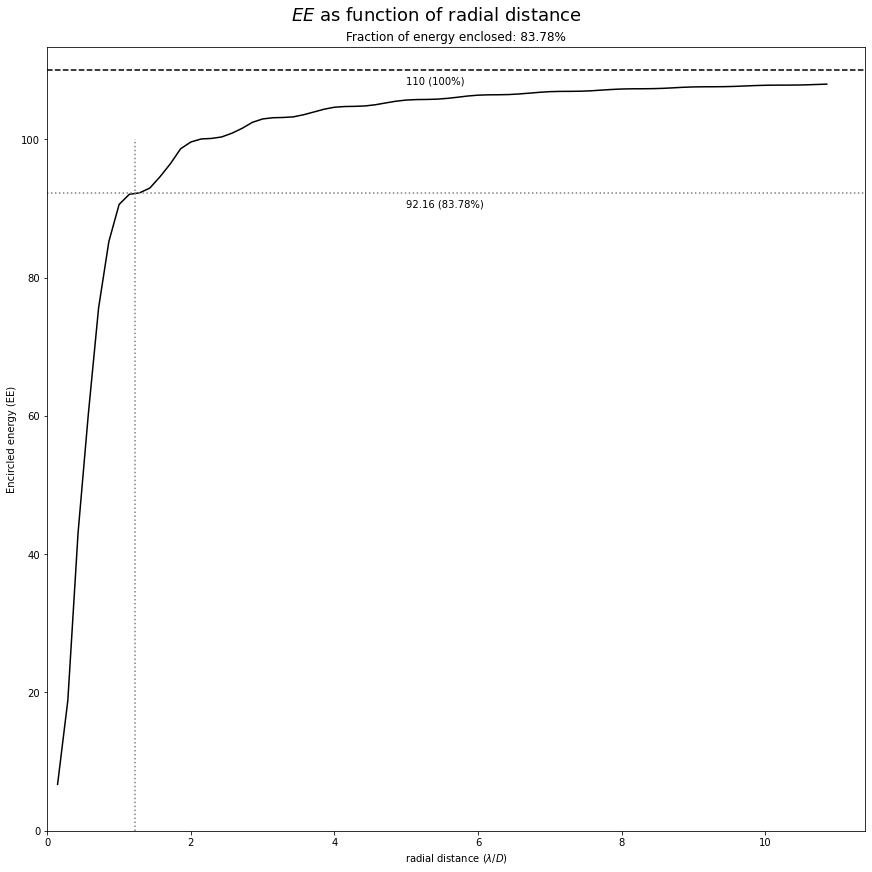

In [24]:
d_apperatures = np.arange(1, 11 * nsamp)
Bn_shape = np.shape(Bn)
EE = ee(Bn, *np.array(Bn.shape)/2, d_apperatures)

# units
app_weird_units_well_no_units_actually = d_apperatures / nsamp
fraction = ee(Bn, *np.array(Bn.shape)/2, [1.22 * nsamp])[0] / 110


# Q5 answer here

# ....

# Q5 end of answer

print('The fraction of encircled energy at 1.22 l/D is:', fraction)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(app_weird_units_well_no_units_actually, EE, c="k")
ax.plot(np.array([1.22, 1.22]), np.array([0, 100]), c="gray", ls="dotted") # this should be an axvline like below
ax.axhline(110 * fraction, c="gray", ls="dotted")
ax.text(5, (110 * fraction) -2, f"{110 * fraction:.2f} ({fraction * 100:.2f}%)")

ax.axhline(110, c="black", ls="dashed")
ax.text(5, (110) -2, f"{110} (100%)")

ax.set_ylim(0, None)
ax.set_xlim(0, None)

ax.set_title(r'Fraction of energy enclosed: 'f'{fraction * 100:.2f}%') 
ax.set_xlabel('radial distance $(\lambda/D)$')                 
ax.set_ylabel('Encircled energy (EE)')               
fig.suptitle('$EE$ as function of radial distance', fontsize=18) 
plt.show()

<a id='part2'></a>

## From telescope pupil to Coronagraph Simulator

Here is a simple optical layout of a telescope, coronagraph, and science imaging camera. The figure is taken from [Sivaramakrishnan and Oppenheimer (2006)](http://adsabs.harvard.edu/abs/2006ApJ...647..620S).

<img src="coronagraph.png">


  * A is the telescope entrance pupil
  * B is the first focal plane
  * $m(k)$ is the focal plane coronagraphic mask
  * C is the masked first focal plane
  * D is the Lyot pupil plane
  * $N(x)$ is the Lyot pupil plane coronagraphic mask
  * E is the masked Lyot plane
  * F is the final focal plane
  
Many types of coronagraph can be specified with $m(k)$ and $N(x)$, resulting in attenuation for on-axis sources whilst letting as much light from a nearby companion through.

The axis of the coronagraph is at  the central pixel `xcen,ycen` of `B`, `C` and `F`, and we will refer to this pixel as being at the origin, i.e. $(x,y)=(0,0)$ for the central pixel.

---

> This week we will make a Lyot coronagraph and compare its efficiency at transmitting and rejecting light compared to direct imaging. We define the function `coro()` which produces the final science camera focal plane image `F` and all the intermediate planes. 

In [9]:
def coro(A, m, N, nsamp):
    """coro - simulated Lyot coronograph taking a telescope pupil 'A', transmissive masks 'm' and 'N'
            and a sampling number 'nsamp' that returns  the final science camera focal plane image 'F' 
            and all the intermediate planes."""
    B = FFT(A,nsamp)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)
    # nice clear names ;)

    return(B,C,D,E,F)

First things first - let's see that `coro()` works by putting in two fully transmissive masks for `m` and `N`. Remember that both masks will have to be padded to the same size as `B` in order for `coro()` to work. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span> 

**Use the telescope pupil `A` with `Isum = 110.0` and `nsamp=7`, and show that the `Isum` of `B`,`C`,`D`,`E` and `F` are all equal to `110.0` (or at least very close to this, depending on numerical precision).**


<div class="alert alert-block alert-info">
<b>Hint:</b>  Remember that you will have to correct the intensities according to the relation you found out earlier in the notebook.</div>

---

In [10]:
# Q6 answer here

n = np.ones_like(Bn)


B,C,D,E,F = coro(A, n, n, nsamp)
Alyot = Isum(A)
Blyot = Isum(B/Bn.shape[0])
Clyot = Isum(C/Bn.shape[0])
Dlyot = Isum(D)
Elyot = Isum(E)
Flyot = Isum(F/Bn.shape[0])

# Q6 end of answer

# Check the throughput

print('Throughput: A={:.2f} B={:.2f} C={:.2f} D={:.2f} E={:.2f} F={:.2f}'.format(Alyot,Blyot,Clyot,Dlyot,Elyot,Flyot))                    # f string crying in the distance

Throughput: A=110.00 B=110.00 C=110.00 D=110.00 E=110.00 F=110.00


We put the star we wish to block on the central axis of the coronagraph - this is done already with telescope pupil `A`, normalised to `Isum(A) = 100.0`.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make a copy of `A` using `np.copy()` and call it `A_star`, and use `coro()` to generate the ASF (i.e. keep it a complex amplitude all the way through the coronagraph!) at the first focal plane and call it `B_star`. Show the resultant PSF of the star in the first focal plane `B` using `displC(B_star, 161)`**

---

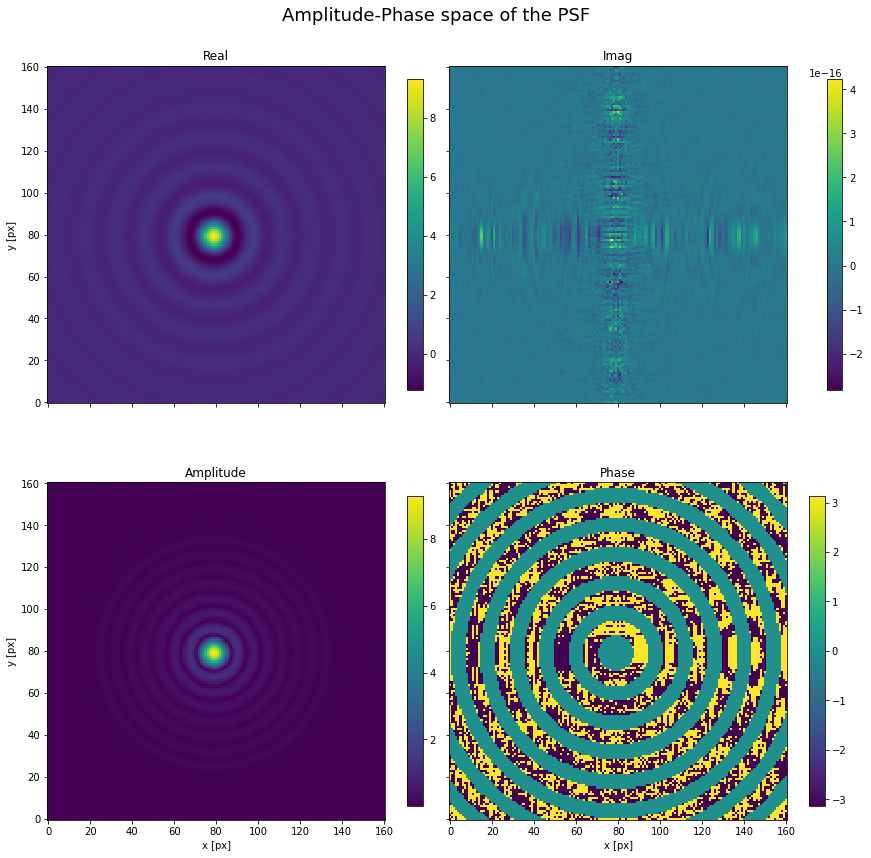

In [11]:
# Q7 answer here


# Some weird stuff happening there, the imaginary value should be zero (it is very close)
# and the phase should also be zero (it is also close since its almost +/- pi)
# I suspect its something to do with floating point precision of the arrays 
# since the differences are roughly on the scale of the absolute accuracy of float64 arrays


A_star = A.copy() # its better in this case to use copy.deepcopy() to avoid some issues with data references in np arrays
B_star = coro(A_star, n, n, nsamp)[0]
displC(B_star/A_star.shape[0], trim=161) # fonky

# Q7 end of answer

We can now make a planet that is 10000 times fainter **in energy** than the star, and move it off the axis of the coronagraph by adding a tilt in phase across the telescope pupil.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.8</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Make a planet image that is $6 \lambda / D$ along the positive x-axis:**
1. **Make a copy of the star's telescope pupil**
2. **Add a suitable ramp of phase to the telescope pupil - call this `A_planet`** 
3. **Using `coro()` and `displC(B_planet, 161)` show that the resultant PSF of the planet in the first focal plane `B` is moved off of the central axis of the coronagraph.**


<div class="alert alert-block alert-info">
<b>Hint:</b> Go look at <code>phi_ramp()</code> and see what it's doing. </div>

---

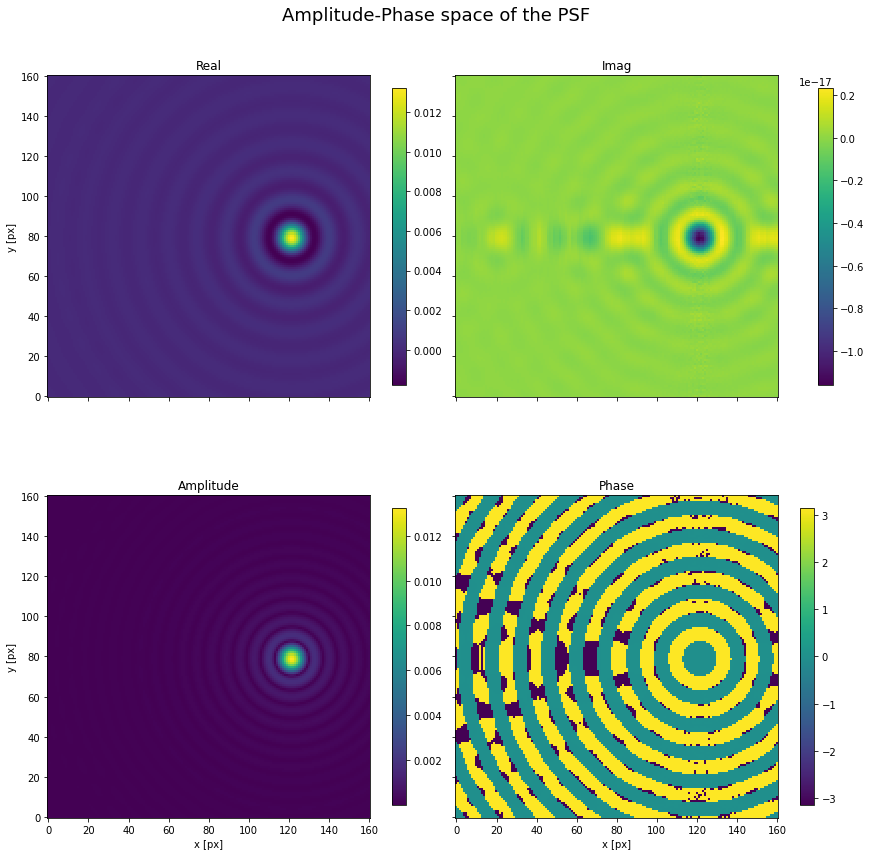

In [12]:
# Q8 answer here

A_star_pupil = A.copy()
amplitude_planet = A_star_pupil / 100


ramp_planet = phi_ramp(A_star_pupil, 6, 0)


A_planet = amplitude_planet * np.exp(1j*ramp_planet)
B_planet = coro(A_planet, 1, 1, nsamp)[0]

displC(B_planet/n.shape[0], trim=161) # even fonkier

# Q8 end of answer

The diffracted light from the star forms a **halo** of light in the science camera focal plane `F`. We can compare the halo of light from the star with the flux from the planet at the $6 \lambda / D$ location. We will do this by plotting the star's PSF and planet PSF and comparing relative fluxes.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.9</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Write a routine `xaxis_energy(im,xr)` that takes a complex image `im`, cuts out the line of pixels from -xr to +xr across the middle of the image (equivalent to $y=0$) and returns the *energy per pixel* along that line.**


---

In [13]:
def xaxis_energy(im, xr):
    """xaxis_energy - takes a complex image im, cuts out the line of pixels from -xr to +xr
            across the middle of the image and returns the energy per pixel along that line"""
    xcen, ycen = (np.array(im.shape)/2).astype(int)
    xax = im[ycen, xcen - xr : xcen + xr]
    E = (xax * xax.conj()).real
    return E



We compare the **direct imaging** case first by looking at the PSFs of the star and the planet in the `B` values.

The peak of the PSF of the star is in the middle of the array `B_star`. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.10</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Plot out the `log10` energy of the PSF centered on the axis of the coronagraph along the x axis from -10 to + 10 $\lambda/D$ . The x-axis should be labelled in units of $\lambda/D$.**  **Plot the planet's PSF on the same graph as the PSF of the star. Add a label to the plots and show them in a legend.**


<div class="alert alert-block alert-info">
<b>Sanity Check:</b>  You should see that the planet's peak flux is slightly below the stellar halo at $6 \lambda/D$.</div>

<div class="alert alert-block alert-info">
<b>Tip:</b>  You can simply add more than one plot to a graph by adding more plots in one axis using ax.plot(planet), ax.plot(star).</div>

---


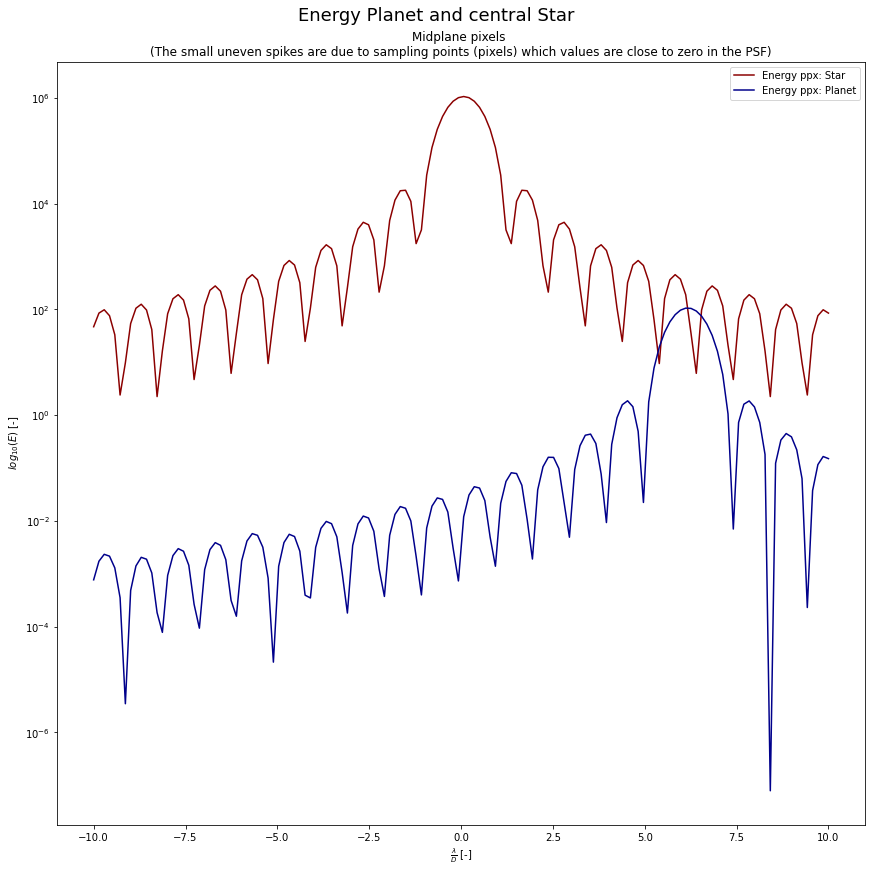

In [14]:
# Q10 answer here

n = 10

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))


E_star = xaxis_energy(B_star, n * nsamp)
E_planet = xaxis_energy(B_planet, n * nsamp)

x = np.linspace(-n, n, 2 * n * nsamp)

ax.plot(x, E_star, label="Energy ppx: Star", c="darkred")
ax.plot(x, E_planet, label="Energy ppx: Planet", c="darkblue")

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels \n(The small uneven spikes are due to sampling points (pixels) which values are close to zero in the PSF)')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet and central Star', fontsize=18) 
plt.show()

# Q10 end of answer

### Finally, let's put in a classical Lyot coronagraph!

A classical Lyot coronagraph consists of a hard-edged occulter in the first focal plane, followed by a Lyot stop in the second pupil (the Lyot) plane.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.11</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Make a hard edged mask `m_lyot` that has a radius of $3 \lambda/D$. It should have a transmission of 0 within this radius, and a transmission of 1 outside this radius. Assume there is no phase change with light passing through the mask.**

**Display the effect of the mask `m_lyot` on the planet's PSF `B_planet` by calculating `C_planet` and then use `displC(x, 151)`**

---


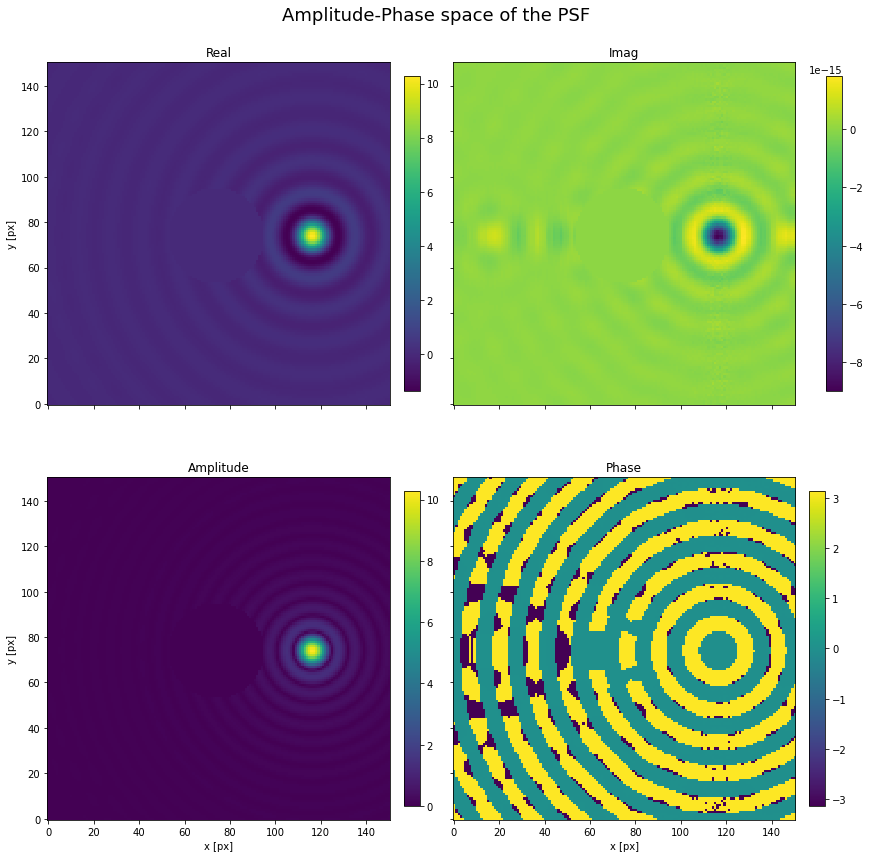

In [15]:
# Q11 answers here

m_lyot = np.abs(circle_mask(B_planet,
                            B_planet.shape[0] // 2,
                            B_planet.shape[0] // 2,  3 * nsamp) - 1)



C_planet = B_planet * m_lyot
displC(C_planet, trim=151)


# Q11 end of answer


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.12</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

1. **Make the Lyot stop `N_lyot` so that it blocks all light outside 0.8 times the diameter of the pupil at location `D` in the coronagraph, and run the coronagraph simulator for both the star and the planet. Display the result using `displC(N_lyot)`**
2. **Make the same logarithmic energy plots with the same x-axis range for the final science camera plane `F_star` and `F_planet`.**

**Which object is brighter at $6 \lambda/ D$ now?**

---


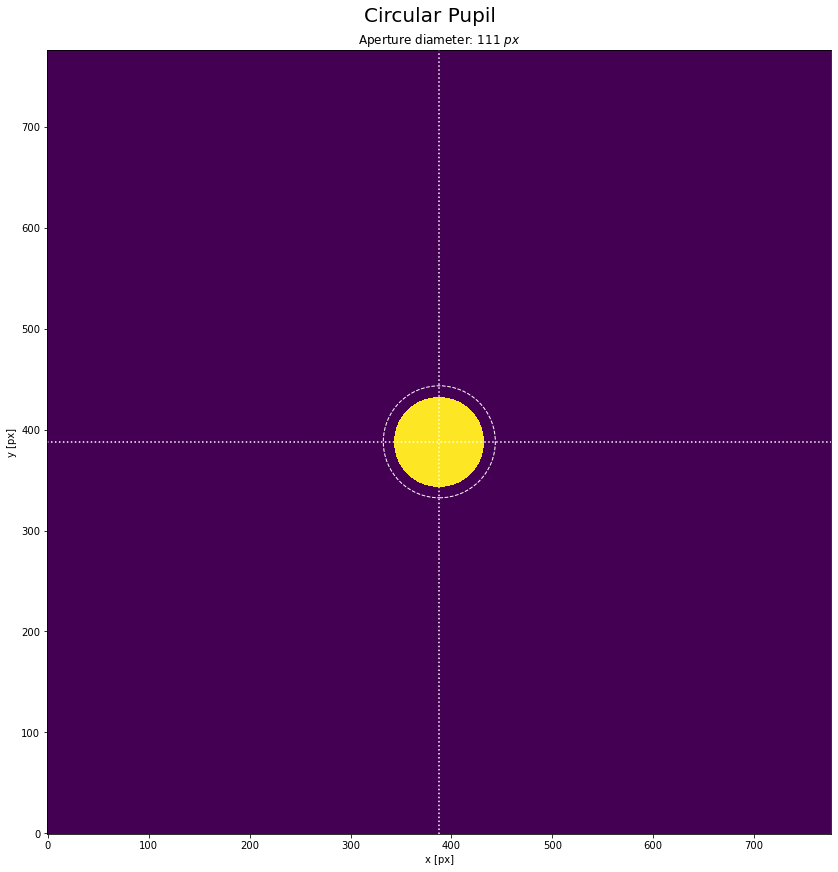

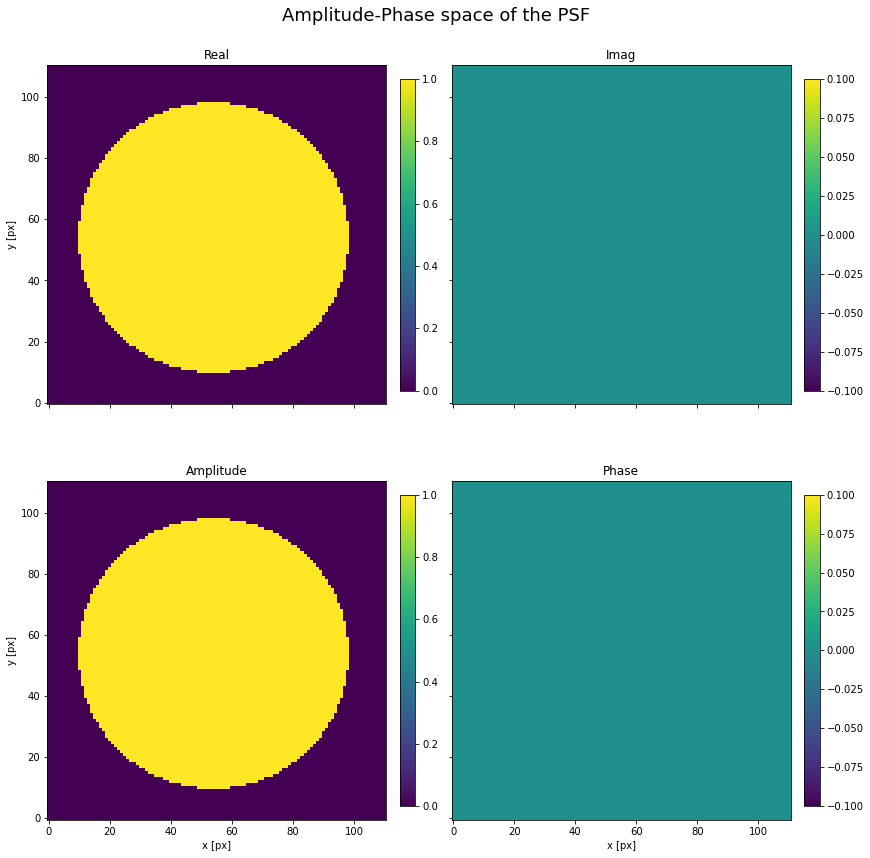

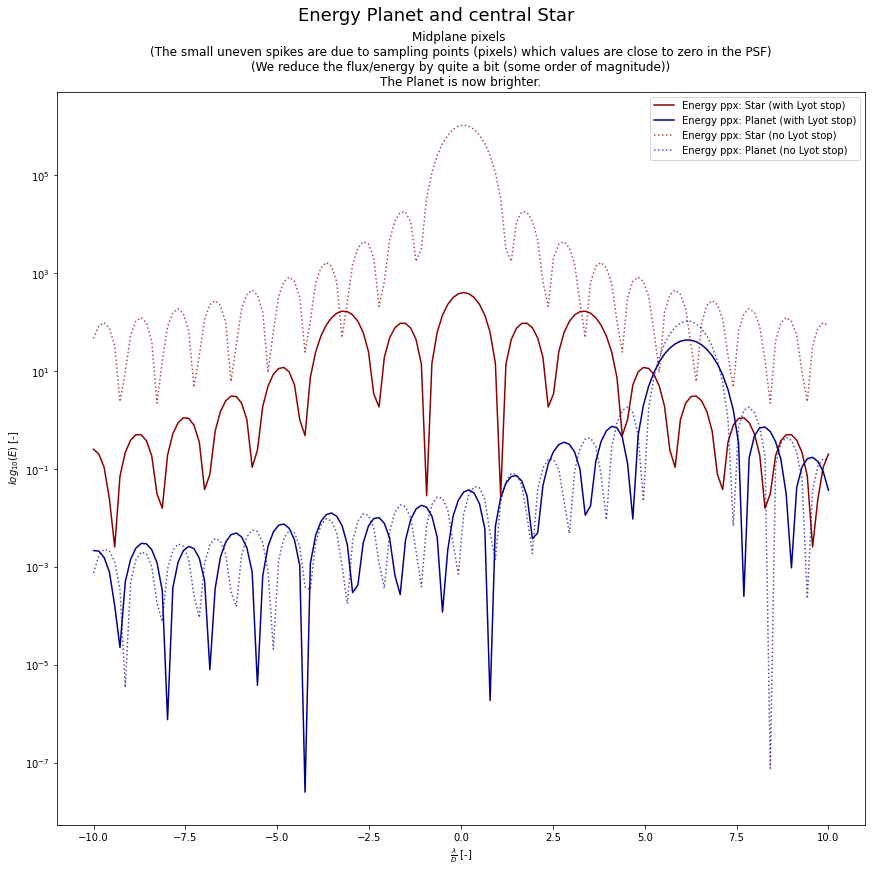

In [16]:
# Q12 answer here

N_lyot = circle_mask(B_planet,
                     B_planet.shape[0] // 2,
                     B_planet.shape[0] // 2,
                     0.8 * (B_planet.shape[0] // 2) / nsamp)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))
plt.imshow(N_lyot)
ax.axvline(B_planet.shape[0] // 2, c="w", ls="dotted")
ax.axhline(B_planet.shape[0] // 2, c="w", ls="dotted")

p = mpl.patches.Circle((B_planet.shape[0] // 2, B_planet.shape[0] // 2), dtel/2,
                        fc="none", ec="w", ls="dashed")
ax.add_artist(p)

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title(r'Aperture diameter: $111~px$') 
fig.suptitle(r'Circular Pupil', fontsize=20)
plt.show()

displC(N_lyot, trim=111)


F_planet = coro(A_planet, m_lyot, N_lyot, nsamp)[4]
F_star = coro(A_star, m_lyot, N_lyot, nsamp)[4]

E_star_F = xaxis_energy(F_star,  n * nsamp)
E_planet_F = xaxis_energy(F_planet, n * nsamp)



fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, E_star_F, label="Energy ppx: Star (with Lyot stop)", c="darkred")
ax.plot(x, E_planet_F, label="Energy ppx: Planet (with Lyot stop)", c="darkblue")

ax.plot(x, E_star, label="Energy ppx: Star (no Lyot stop)", c="darkred", ls="dotted", alpha=0.7)
ax.plot(x, E_planet, label="Energy ppx: Planet (no Lyot stop)", c="darkblue", ls="dotted", alpha=0.7)

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels \n(The small uneven spikes are due to sampling points (pixels) which values are close to zero in the PSF)\n(We reduce the flux/energy by quite a bit (some order of magnitude))\nThe Planet is now brighter.')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet and central Star', fontsize=18) 
plt.show()


# Q12 end of answer

The planet is now brighter than the star at the planets central location. Since this is a log scale its actually brighter by quite a lot. Since the airy disks are offset from each other the planet airy disks might also be visible in the valles of the airy disk of the star, even some maxima/minima removed from the position of the planet.


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.13</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Overplot `B_star` and `F_star` on the same plot. Estimate by eye the suppression factor of the coronagraph by looking at the peak of the PSFs.**

---

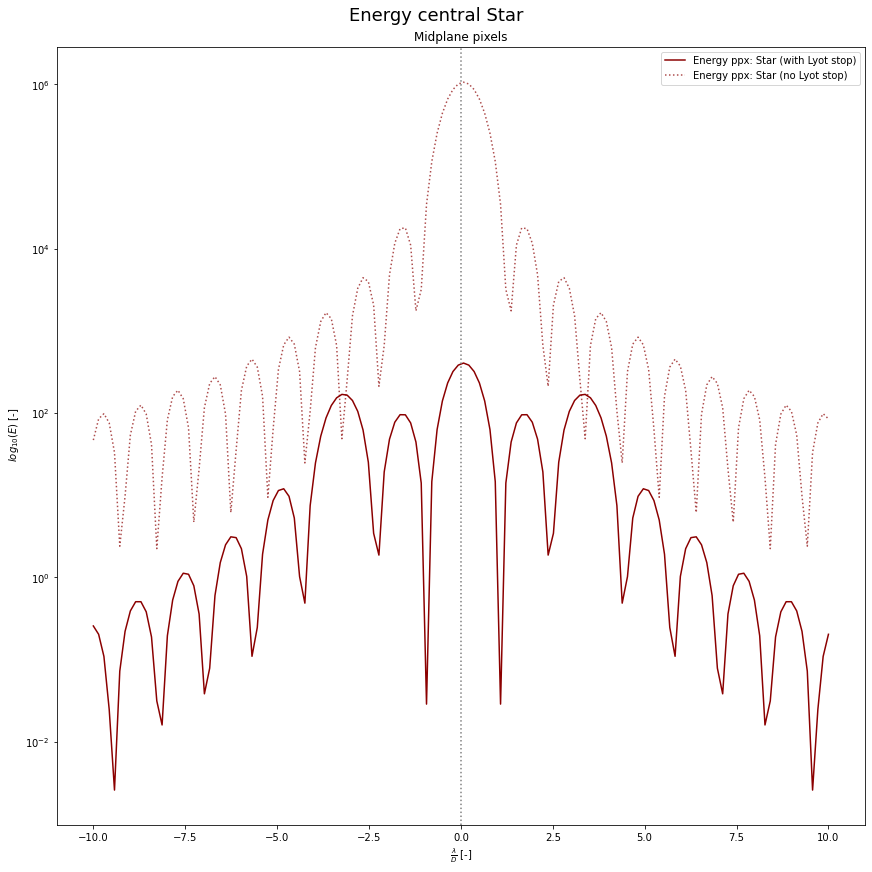

By looking at the peak of the PSFs the suppression factor of the coronagraph: 2.62e+03 ( or 3.82e-04 I guess)


In [17]:
# Q13 answer here
# I guess I was doing that actually before as well, but here it goes

# lets try smoothing by colvolving, thats a good trick!

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

def smooth(data, r):
    """
    Smoothes data by convolving with a constant function in a radius r/2 (on x axis)
    """
    smoothing_region = np.ones(r) / r
    smooth_data = np.convolve(data, smoothing_region, mode='same')
    return smooth_data

# I was about do do this but we were just supposed to look at the center. Which makes sense of course since the Lyot stop doent affect the whole disk.
# r = 10
# ax.plot(x, smooth(E_star_F, r), label=f"Energy ppx: Star (with Lyot stop) (convolved with c, r={r/2:.1f})", c="purple", ls="dashed", alpha=0.4)
# ax.plot(x, smooth(E_star, r), label=f"Energy ppx: Star (no Lyot stop) (convolved with c, r={r/2:.1f})", c="purple", ls="dashed", alpha=0.4)


ax.plot(x, E_star_F, label="Energy ppx: Star (with Lyot stop)", c="darkred")
ax.plot(x, E_star, label="Energy ppx: Star (no Lyot stop)", c="darkred", ls="dotted", alpha=0.7)

F_suppression = (E_star / E_star_F)[int(len(E_star)/2)]
ax.axvline(0, ls="dotted", c="gray")

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy central Star', fontsize=18) 
plt.show()

# Q13 end of answer

# Q13 end of answer

print(f"By looking at the peak of the PSFs the suppression factor of the coronagraph: {F_suppression:.2e} ( or {1/F_suppression:.2e} I guess)")


---
<span style="  font-size:2em; color: SteelBlue;">Question 3.14</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Overplot `B_planet` and `F_planet`. What has happened to the Airy rings? Why?**

---


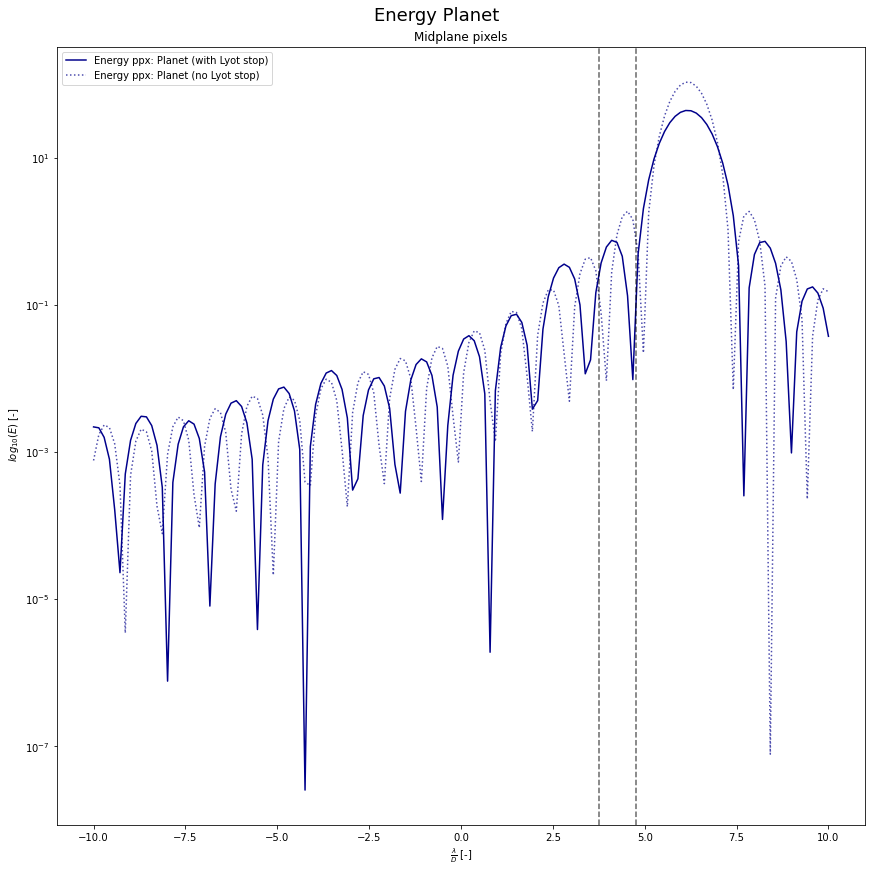

By looking at the peak of the PSFs the suppression factor of the coronagraph (planet): 2.42e+00 ( or 4.13e-01 I guess)
The Airy rings are fainter (when comparing the same maxima, not necessarily at the same separations)
Furthermore it is compressed (maxima at smaller separations) since the aperture is smaller (due to the Lyot stop).
Naively we would expect the the disks are compressed by a factor of 0.8 since the airy disk rings scale as lambda / D
If we actually check this we find a compresseion factor (x axis) of 0.786 by checking the first maxima. 
Thats close enough.


In [18]:
# Q14 answer here

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, E_planet_F, label="Energy ppx: Planet (with Lyot stop)", c="darkblue")
ax.plot(x, E_planet, label="Energy ppx: Planet (no Lyot stop)", c="darkblue", ls="dotted", alpha=0.7)


F_suppression = (np.max(E_planet) / np.max(E_planet_F))

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet', fontsize=18) 


x1, x2 = 3.75, 4.75
ax.axvline(x1, c="k", ls="dashed", alpha=0.6)
ax.axvline(x2, c="k", ls="dashed", alpha=0.6)

idx1 = (x1 < x) & (x < x2)

idx_center = np.where(E_planet == np.max(E_planet))


xidx1 = np.where(E_planet_F == np.max(E_planet_F * idx1))
xidx2 = np.where(E_planet == np.max(E_planet * idx1))
comp = 1 / ((x[xidx1] - x[idx_center]) / (x[xidx2] - x[idx_center]))[0]

plt.show()
# Q14 end of answer

print(f"By looking at the peak of the PSFs the suppression factor of the coronagraph (planet): {F_suppression:.2e} ( or {1/F_suppression:.2e} I guess)")

print("The Airy rings are fainter (when comparing the same maxima, not necessarily at the same separations)\n"\
     "Furthermore it is compressed (maxima at smaller separations) since the aperture is smaller (due to the Lyot stop).") 
print(f"Naively we would expect the the disks are compressed by a factor of 0.8 since the airy disk rings scale as " + r"lambda / D" + f"\n"\
      f"If we actually check this we find a compresseion factor (x axis) of {comp:.3f} by checking the first maxima. \nThats close enough.")

The star and the planet are incoherent sources with respect to each other, and so the image on the sky is the sum of their separate intensities.

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.15</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Make an intensity image of the star and planet before the coronagraph, and display it with `displC(logit(x),161)`.**

**Make an image after the coronagraph as well. You should be able to see the planet.**

---


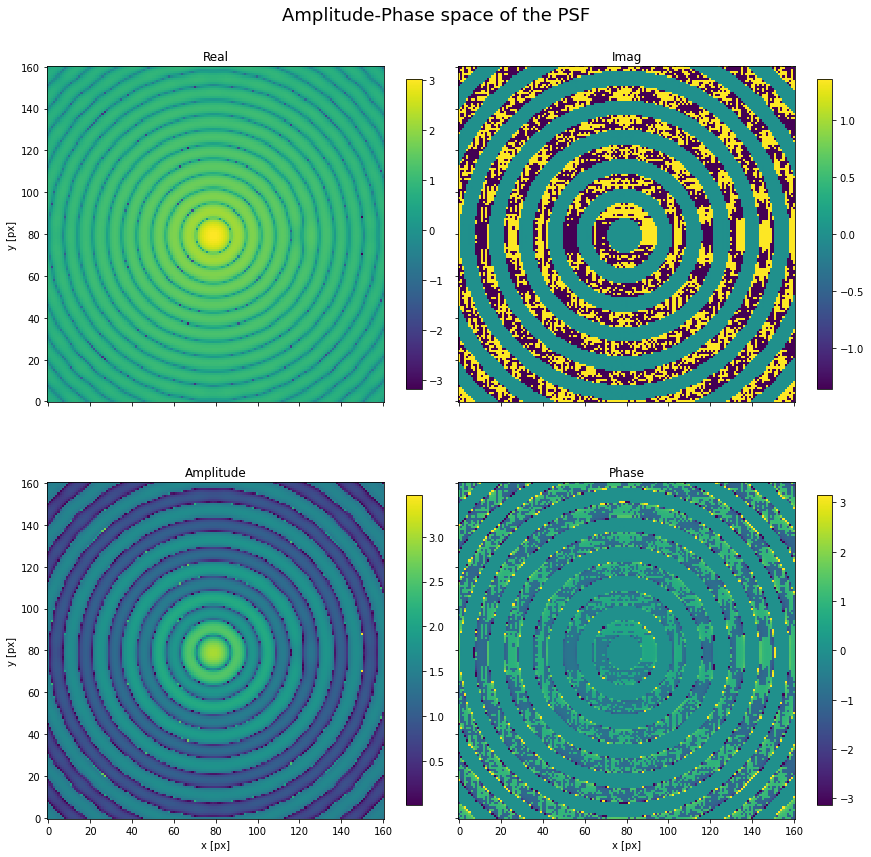

In [19]:
# Q15 answer here
displC(logit(B_star+B_planet), trim=161)
# .... before

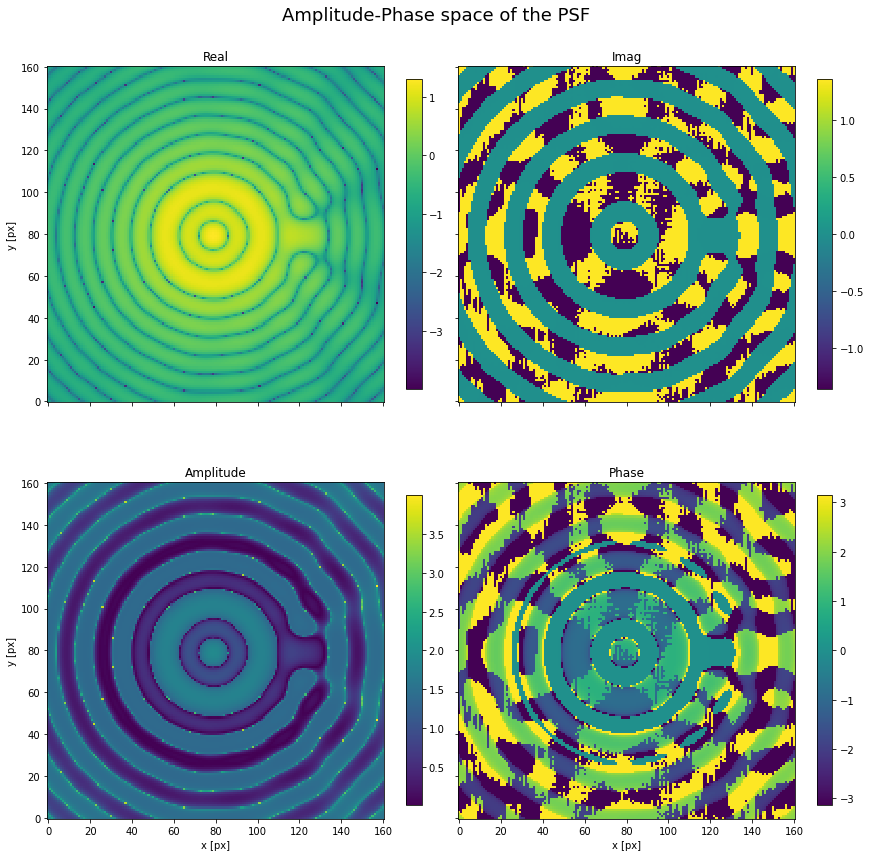

In [20]:
# .... after
displC(logit(F_star+F_planet), trim=161)
# Q15 end of answer

---
<span style="  font-size:2em; color: SteelBlue;">Question 3.16</span> <span style="  font-size:1em; color: SteelBlue;">
(8 points): </span>

**Adjust the Lyot stop size from 0.5 to 1.0 times the diameter of the pupil, and adjust the diameter of the hard-edged stop so that you <span style="  font-size:1.2em; color: Red;">optimise</span>  the brightness of the planet compared to the stellar halo. What are the problems that you find with small Lyot stops?**

---

Optimise spotted!

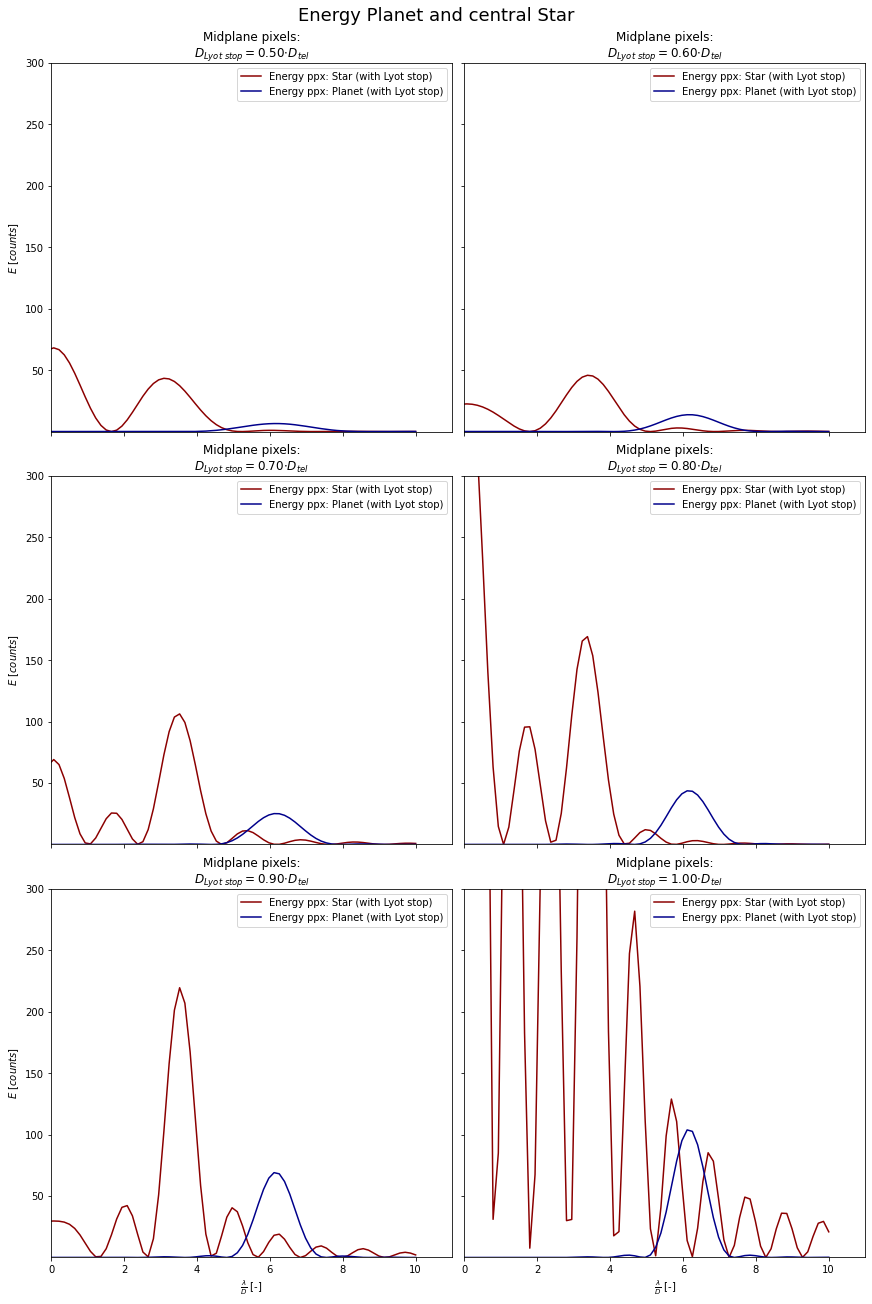

In [21]:
# Q16 answer here

lyot_size = np.linspace(0.5, 1., 6)

fig, axes = plt.subplots(nrows=3, ncols=2,
                         constrained_layout=True,
                         sharex=True, sharey=True,
                         figsize=(12, 18))

for lyot, ax in zip(lyot_size, np.array(axes).flatten()):
    N_lyot = circle_mask(B_planet,
                     B_planet.shape[0] // 2,
                     B_planet.shape[0] // 2,
                     lyot * (B_planet.shape[0] // 2) / nsamp)


    F_planet = coro(A_planet, m_lyot, N_lyot, nsamp)[4]
    F_star = coro(A_star, m_lyot, N_lyot, nsamp)[4]

    E_star_F = xaxis_energy(F_star, n * nsamp)
    E_planet_F = xaxis_energy(F_planet, n * nsamp)
    
    
    
    ax.plot(x, E_star_F, label="Energy ppx: Star (with Lyot stop)", c="darkred")
    ax.plot(x, E_planet_F, label="Energy ppx: Planet (with Lyot stop)", c="darkblue")

    # ax.plot(x, E_star, label="Energy ppx: Star (no Lyot stop)", c="darkred", ls="dotted", alpha=0.7)
    # ax.plot(x, E_planet, label="Energy ppx: Planet (no Lyot stop)", c="darkblue", ls="dotted", alpha=0.7)
    
    ax.set_ylim(np.min(np.stack((E_star_F, E_planet_F)).flatten()), 300.)
    ax.set_xlim(0, None)

    ax.set_title(f"Midplane pixels:\n"r"$D_{Lyot~stop} = $"f"{lyot:.2f}" r"$\cdot D_{tel}$")
    
    # ax.set_yscale("log")
    ax.legend()

for i in [4,5]:
    np.array(axes).flatten()[i].set_xlabel(r"$\frac{\lambda}{D}$ [-]")
for i in [0,2,4]:
    np.array(axes).flatten()[i].set_ylabel(r"$E$ [$counts$]")
fig.suptitle('Energy Planet and central Star', fontsize=18) 
plt.show()

# Q16 end of answer

Optimise for maximum energy fraction at the planet location. I compare the peak of the planet flux (energy) with the peak fo the star flux within +/- lamda/D in order to get a good estimate how "clear" the region around the planet is. I also widen the bounds a little because I want to know how the function looks when we decrease the Lyot stop size even more. Very small Lyot stops are almost certianly not a good design point since the energy flux is very strongly reduced (and at some point we actually properly mask out the planet). Probably an even nicer way to do this is to maximize the energy enclosed in a circle around the maximum planet bightness (e.g. inside the first minima).

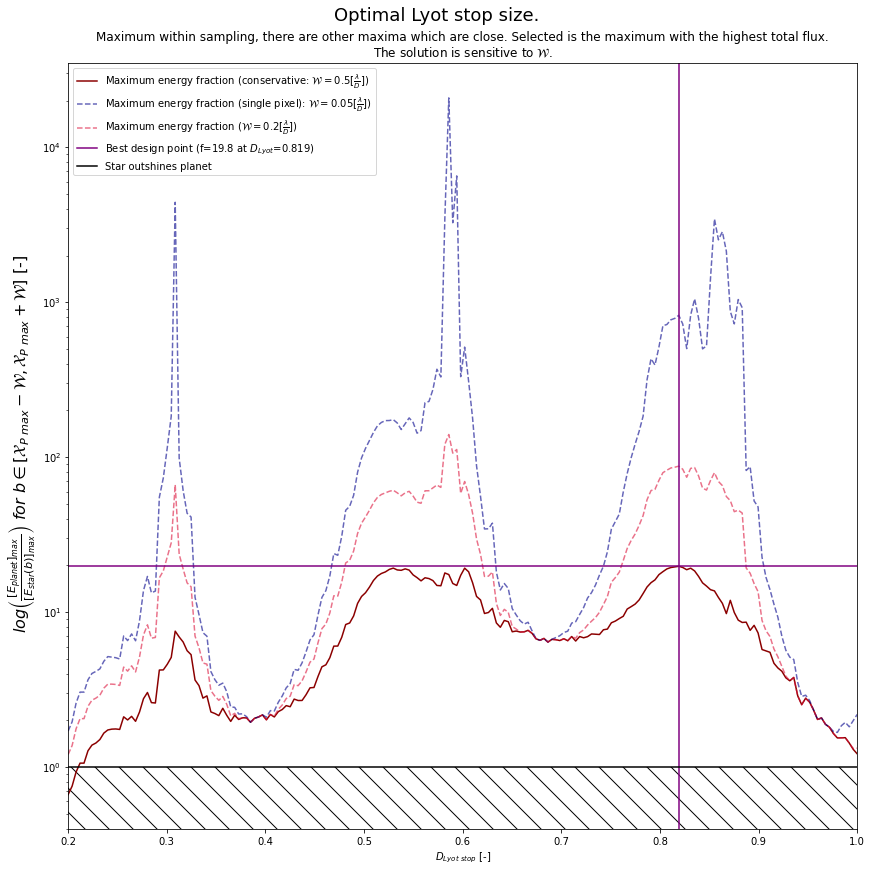

In [22]:
# Q16 answer here
# this might run a while...
lyot_size_bounds =(0.2, 1.)
how_many_checks = 200
lyot_x = np.linspace(*lyot_size_bounds, how_many_checks)

def get_e_frac(lyot_size=0.8, window=0.5):
    N_lyot = circle_mask(B_planet,
                     B_planet.shape[0] // 2,
                     B_planet.shape[0] // 2,
                     lyot_size * (B_planet.shape[0] // 2) / nsamp)
    
    x1, x2 = nsamp - window, nsamp + window
    idx1 = (x1 < x) & (x < x2)


    F_planet = coro(A_planet, m_lyot, N_lyot, nsamp)[4]
    F_star = coro(A_star, m_lyot, N_lyot, nsamp)[4]

    E_star_F = xaxis_energy(F_star, n * nsamp)
    E_planet_F = xaxis_energy(F_planet, n * nsamp)
    
    frac = np.max(E_planet_F) / np.max(E_star_F * idx1)
    
    return frac

def wrap_func(lyot_size=0.8):
    return - get_e_frac(lyot_size)

    

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

y = [get_e_frac(s, 0.5) for s in lyot_x]

ax.plot(lyot_x, y, label=r"Maximum energy fraction (conservative: $\mathcal{W}=$"f"{0.5}"r"[$\frac{\lambda}{D}$])",
        c="darkred")
ax.plot(lyot_x, [get_e_frac(s, 0.05) for s in lyot_x], label=r"Maximum energy fraction (single pixel): $\mathcal{W}=$"f"{0.05}"r"[$\frac{\lambda}{D}$])",
        c="darkblue", ls="dashed", alpha=0.6)
ax.plot(lyot_x, [get_e_frac(s, 0.2) for s in lyot_x], label=r"Maximum energy fraction ($\mathcal{W}=$"f"{0.2}"r"[$\frac{\lambda}{D}$])",
        c="crimson", ls="dashed", alpha=0.6)


try:
    try:
        # unless you want to check if this runs, just keep it commented out
        # no idea, but it is convinced that the maximum is at 0.6, probably some stopping criterion
#         from scipy.optimize import shgo
        
#         res = shgo(wrap_func,
#                    bounds=[(0.2, 1.)],
#                    n=200,
#                    sampling_method="simplicial")
#         print(res)
#         ymax = res.funl[0]
#         xmax = res.x[0]
        pass
        
    except (NameError, ImportError, ModuleNotFoundError):
        print("So something/somebody is actually checking if we have any additional imports.\n"\
              "I wonder if you just run these on a dedicated virtual environment where you only include the allowed packages.")
        pass
except BaseException:
    # just making sure that no matter what cursed environment you guys have this will still run
    pass

idxmax = np.argmax(y)

xmax = lyot_x[idxmax]
ymax = y[idxmax]

ax.axvline(xmax, ls="solid", c="purple", label=f"Best design point (f={ymax:.1f} at "r"$D_{Lyot}$="f"{xmax:.3f})")
ax.axhline(ymax, ls="solid", c="purple")

ax.axhline(1, ls="solid", c="k", label="Star outshines planet")

ax.set_xlim(*lyot_size_bounds)
plt.legend()
ax.set_title(f'Maximum within sampling, there are other maxima which are close. Selected is the maximum with the highest total flux.\n'+r'The solution is sensitive to $\mathcal{W}$.')  
ax.set_xlabel(r"$D_{Lyot~stop}$ [-]")

ax.fill_between(lyot_size_bounds, 1, facecolor="none", hatch="\\", edgecolor="k", linewidth=0.0, label="Star outshines planet")

ax.set_yscale("log")
ax.set_ylabel(r" $log\left(\frac{[E_{planet}]_{max}}{[E_{star}(b)]_{max}}\right) ~ for ~ b \in [\mathcal{X}_{P~max} - \mathcal{W}, \mathcal{X}_{P~max} + \mathcal{W}]$ [-]", fontsize=16)
fig.suptitle('Optimal Lyot stop size.', fontsize=18) 
plt.show()


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [23]:
# Number of hours taken for this practicum:
# probably 6ish total
# 1 h of which on the last
